# Discordance analysis

In this example we will analyse the discordance between gene-trees and species tree for the trees in phylome 15 with three different ways:

1. GeneRax
2. EcceTERA
3. Abaccus

In [1]:
import os
os.chdir("..")

In [5]:
import analyse_phylome as ap
from ete3 import Tree

outDir = "./out_dir15"
sptree = "./data/rooted_phylome_15_sp_duptree.txt"
# see example_cat to see how to get these files
treeFile = "./test_data/best_trees15.txt"
aln_dir = "./test_data/all_algs_15"

out_sprax = outDir + "/grax15"

##### GeneRax

"GeneRax is a parallel tool for species tree-aware maximum likelihood based gene family tree inference under gene duplication, transfer, and loss.

It infers gene family trees from their aligned sequences, the mapping between genes and species, and a rooted undated species tree. In addition, it infers the duplication, transfer and loss events that best (in terms of maximum likelihood) reconcile the gene family trees with the species trees. It accounts for sequence substitutions, gene duplication, gene loss and horizontal gene transfer." [repo here](https://github.com/BenoitMorel/GeneRax)

GeneRax uses raxml parser to read alignment file. This causes an issue as raxml does not accept U (Selenocysteine) that is present in few phylomes. Thus, before creating data you can run the function scan_for_Us() and decide to replace the character with any other (C by default). This will create  copy of the alignment called "id.clean_noUs.fasta" that later will be added to the family file instead of the original alignment.

In [4]:
ap.scan_for_Us(aln_dir)

No files contain U


If some alignments with Us are found set replace=True and the function will create the alignments with U replaced with C (by default, but the replacement character can be set. Also the character to be replaced can be set although it should not be needed). The new alignments will have "noU" extension and get_generax_data function will use those instead of the original ones.

To get the data needed we run this function that will create the necessary folders and family file

In [5]:
ap.get_generax_data(treeFile, out_sprax, aln_dir)


then `mpiexec -np processors generax -s /gpfs/projects/bsc40/gmutti/Second_proj/all_phylomes/rooted_phylome_$i\_sp_duptree.txt --seed 42 --families /gpfs/scratch/bsc40/bsc40122/all_generax/families/$i\_generax_family.txt --strategy EVAL --rec-model UndatedDTL --per-family-rates --prefix /gpfs/scratch/bsc40/bsc40122/all_generax/generax_phylome_$i`


In [6]:
out_res = outDir + "/generax_phylome_15"

grax_df = ap.get_generax_df(out_res)

In [7]:
grax_df.head()

,S,SL,D,T,TL,L,Leaf,Index,S_norm,SL_norm,D_norm,T_norm,TL_norm,L_norm
0,27,11,27,24,0,0,79,Phy008FJJ2_341454,0.341772,0.139241,0.341772,0.303797,0.0,0.0
1,21,6,0,11,0,0,33,Phy008FKAG_341454,0.636364,0.181818,0.000000,0.333333,0.0,0.0
2,1,0,0,1,0,0,3,Phy008FI76_341454,0.333333,0.000000,0.000000,0.333333,0.0,0.0
3,9,2,0,1,0,0,11,Phy008FHKT_341454,0.818182,0.181818,0.000000,0.090909,0.0,0.0
4,2,0,0,3,0,0,6,Phy008FFXV_341454,0.333333,0.000000,0.000000,0.500000,0.0,0.0


[8308:1006/102804.563268:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


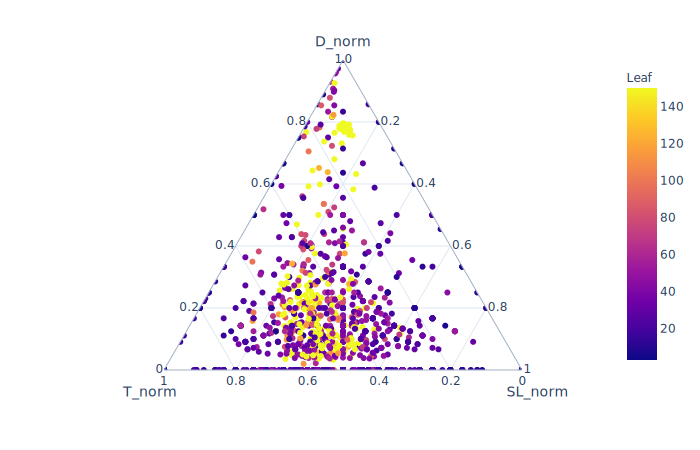

In [8]:
grax_ter = ap.ternary_grax_plot(grax_df, renderer="svg")

Unluckily, GitHub does not render interactive plotly graph. If the argument renderer is ignored the plot will be interactive. Note that the theme can be set with template parameter. See other themes [here](https://plotly.com/python/templates/)

We can also visualize the distribution of the normalized values. By default only the density curve is plotted but with show_rug=True and show_hist=True histogram and rug plot can be added. Further the bin size of hist can be set (default is 0.03).

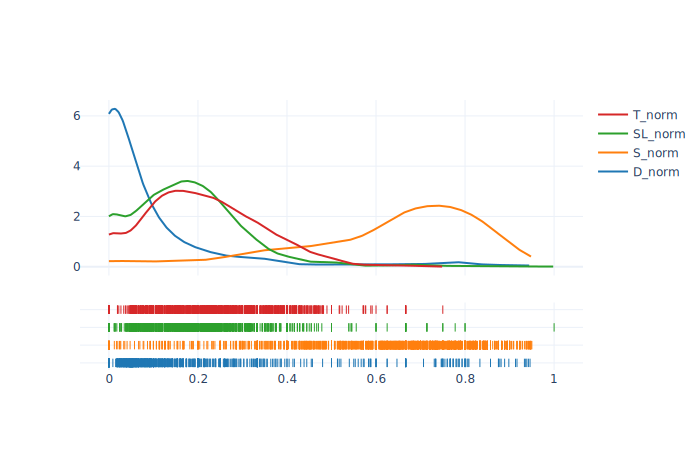

In [10]:
ap.dist_grax_plot(grax_df, show_rug=True, renderer="svg")

Eventually you can visualize one of the reconciliated gene tree saved by GeneRax in nhx format.

In [11]:
tree_random = "./out_dir15/generax_phylome_15/reconciliations/Phy008FIW9_341454_reconciliated.nhx"
phylome_info = "./data/phylome_info15.txt"


tree = Tree(tree_random, format=1)

tax_dict = ap.get_tax_dict_info(phylome_info)

In [12]:
out_gene = ap.annotate_genetree(tree, tax_dict)

ap.viz_grax_tree(out_gene, show=False, render="./out_dir15/plot_grax_Phy008FIW9.png")

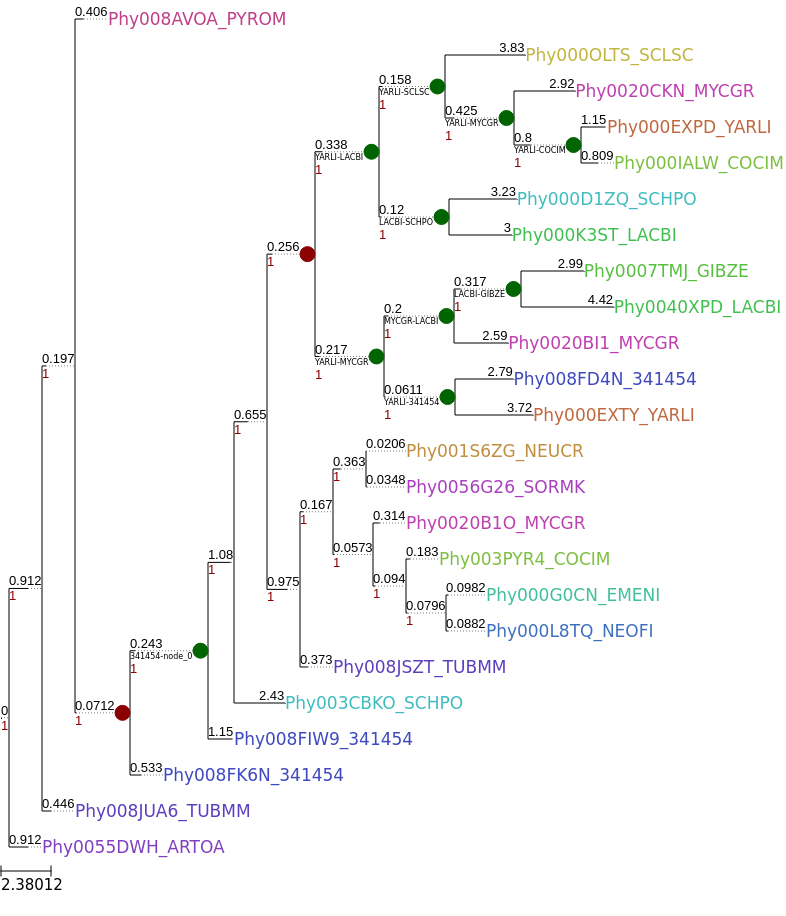

In [13]:
from IPython.display import Image
Image(filename='./out_dir15/plot_grax_Phy008FIW9.png') 

Duplication nodes are annotated with a red circle, whereas transfer nodes with a green one and the species involved in the transfer are written in the node. The leaves are colored by species.

Alternatively you may upload the output recphyloxml file [here](http://phylariane.univ-lyon1.fr/recphyloxml/recphylovisu) to get the gene tree reconciled with the species tree.

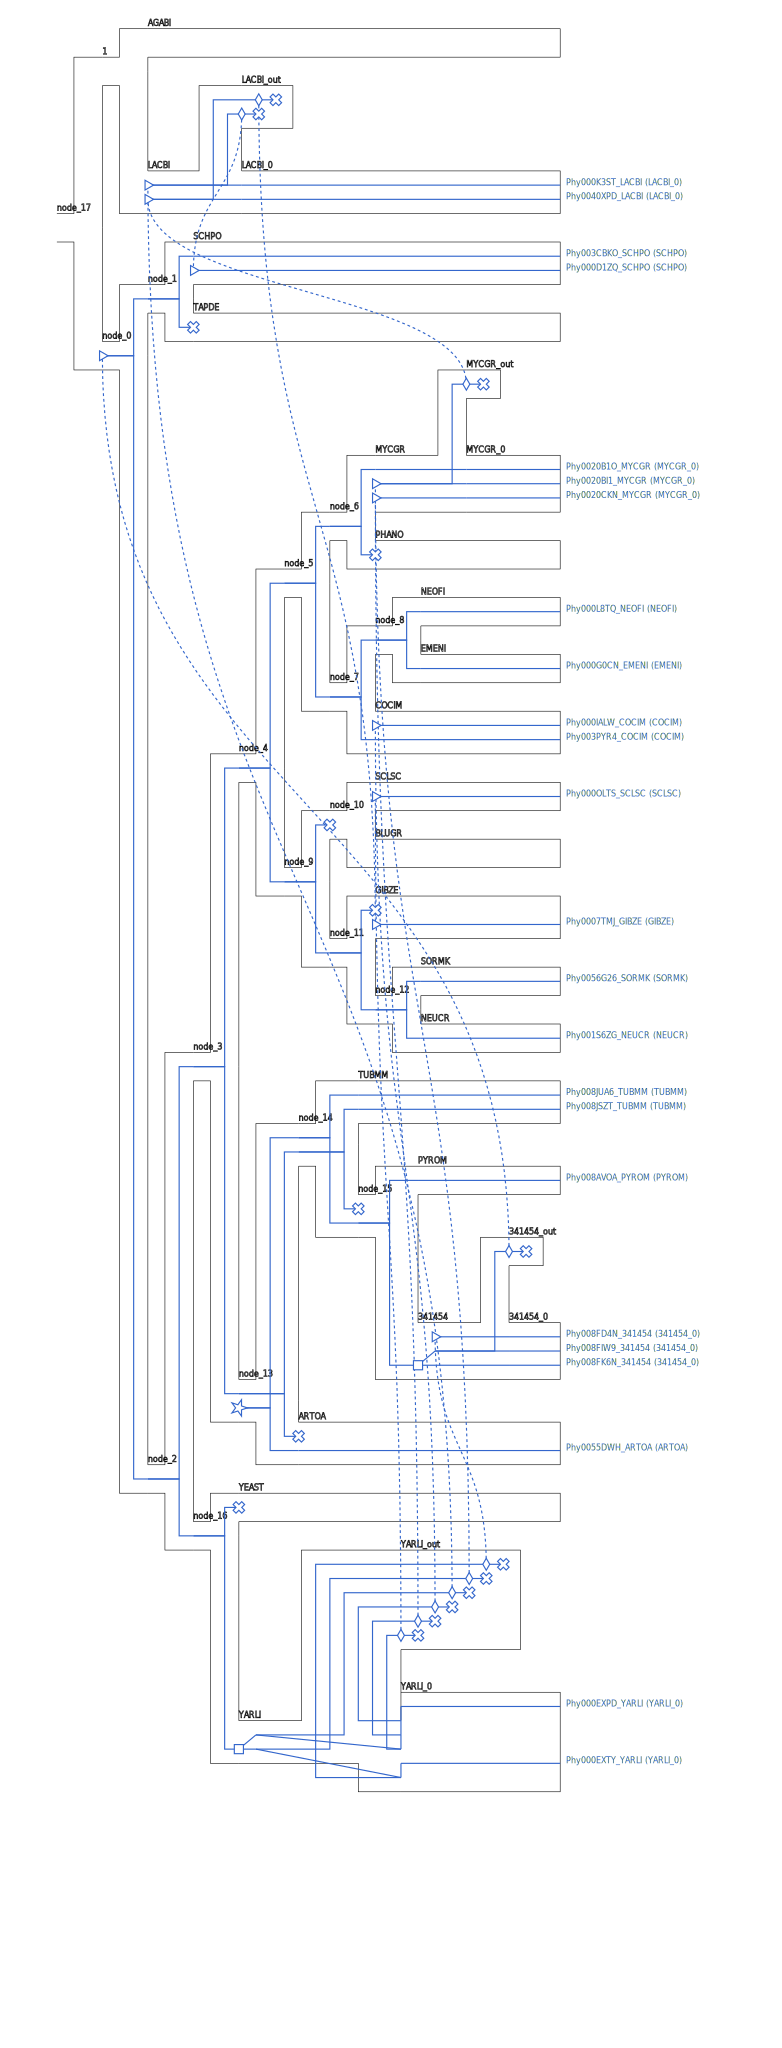

In [14]:
from IPython.core.display import SVG
SVG(filename='./out_dir15/plot_grax_Phy008FIW9_rec.svg')

Alternatively you may load the recphyloxml file through the python utilities from this [repo](https://github.com/WandrilleD/recPhyloXML). First you need to define a parser then you can input a reconciled gene tree. There are some methods defined for this format such as getEventsSummary etc

In [38]:
parser = ap.recPhyloXML_parser()
random_gene = "Phy008FIW9_341454"
tree_random_xml = "./out_dir15/generax_phylome_15/reconciliations/" + random_gene + "_reconciliated.xml"
grax_rec = parser.parse(tree_random_xml)
grax_rec.getEventsSummary()

{'duplication': ['341454', 'YARLI'],
 'loss': ['YEAST', 'node_10', 'GIBZE', 'PHANO', 'ARTOA', 'node_15', 'TAPDE'],
 'transferReception': ['node_0',
  'SCLSC',
  'MYCGR',
  'COCIM',
  'LACBI',
  'SCHPO',
  'MYCGR',
  'LACBI',
  'GIBZE',
  '341454']}

Generax also gives information about the total of per species counts divided by events. Thus, we can read this information with these functions. Note that you'll need to use the species trees you find in generax results species_trees/ folder. It will have the same topology as the input but internal nodes will be named (therefore you have to use format=1). You'll also find per_species_event_counts.txt in the results directory.

In [48]:
sp_tree = "out_dir15/starting_species_tree.newick"
sptree = Tree(sp_tree, format=1)
events_file = "out_dir15/per_species_event_counts.txt"
events_df = ap.read_per_sp_counts(events_file)
events_df.head()

,#S,#SL,#D,#T,#TL
AGABI,2877,0,441,199,0
LACBI,3757,0,1202,281,0
SCHPO,2004,0,209,517,0
TAPDE,1733,0,36,522,0
MYCGR,3522,0,146,970,0


We can then annotate each node with the number of events and visualize them with a piechart. Note that the input tree is copied (with cpickle method) thus you can not input it in the visualiztion function

In [15]:
ann_sptree = ap.annotate_sptree_counts(sptree, events_df)
ap.viz_pies_tree(ann_sptree, show=False, render="./out_dir15/plot_species_events.png") # circular=True

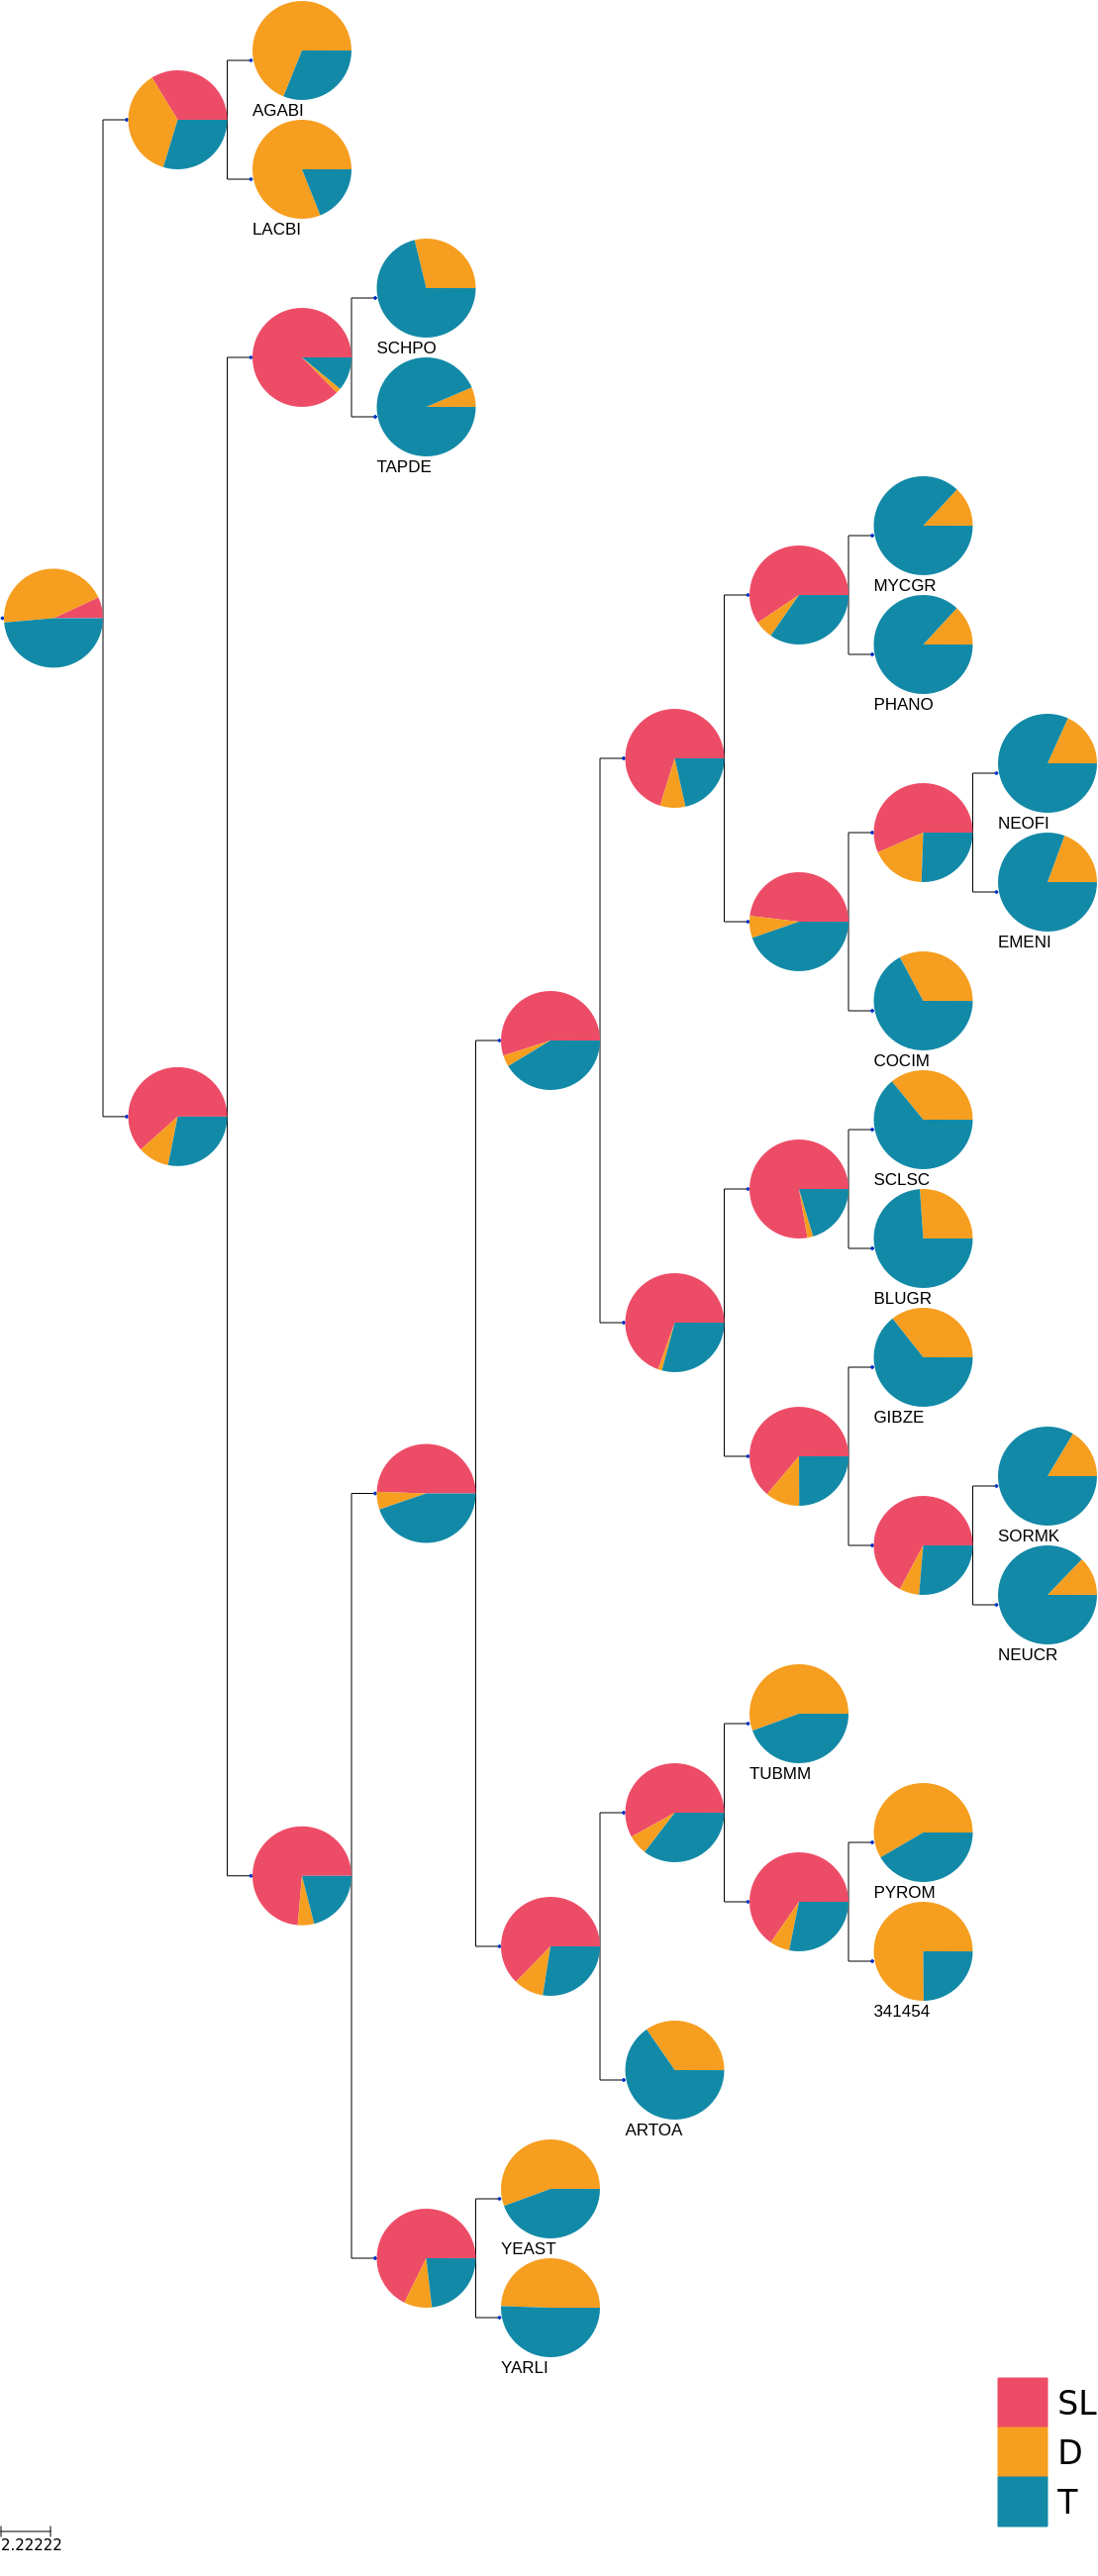

In [16]:
Image(filename='./out_dir15/plot_species_events.png') 

According to GeneRax authors it is also possible to estimate ancestral genome size by summing Speciation and Speciation-Loss events. So, using the same events_df we already created we can visualize the ancestral size of internal nodes with a bubble chart where the radius is proportional to S+SL. 

Note that, due to visualization reasons, ancestral size radius are scaled so that max is 10

In [17]:
anc_size_tree, scale = ap.annotate_sptree_ancsize(ann_sptree, events_df) # need the scale for legend size.
ap.viz_ancsize_tree(anc_size_tree, scale, circular=True, show=False, render="./out_dir15/plot_species_ancsize.png")

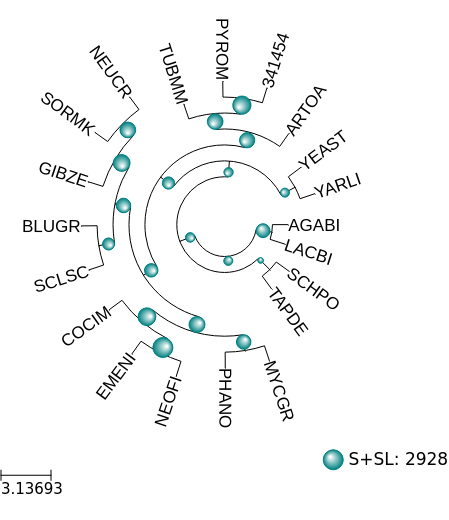

In [18]:
Image(filename='./out_dir15/plot_species_ancsize.png') 

In order to check the results though we can see the presence/absence of each species in the gene families to see if there are problematic species. Thankfully, Generax outputs both fractionMissing.txt and perSpeciesCoverage.txt (for each terminal species, the percentage of gene families that contain a gene of this species at least once). We can simply see the scatterplot of these two indexes. 

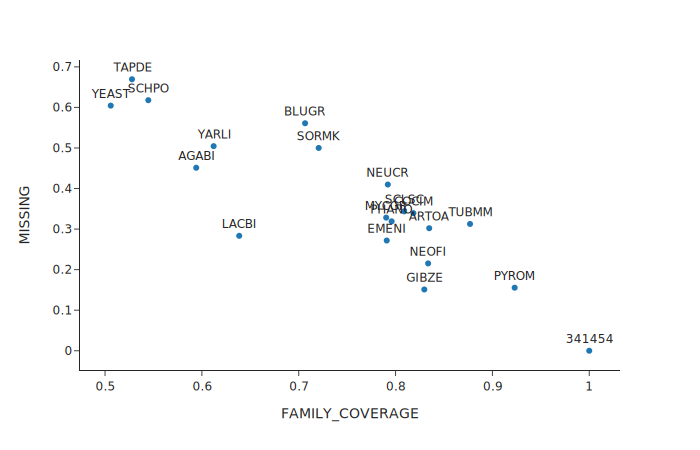

In [9]:
fracmiss = "out_dir15/fractionMissing.txt"
spcov = "out_dir15/perSpeciesCoverage.txt"

df_miss = ap.read_missingcov(fracmiss, spcov)
ap.plot_missingcov(df_miss, renderer="svg") # text=False if no label

### ecceTERA

"A gene tree-species tree reconciliation explains the evolution of a gene tree within the species tree given a model of gene-family evolution. We describe ecceTERA, a program that implements a generic parsimony reconciliation algorithm, which accounts for gene duplication, loss and transfer (DTL) as well as speciation, involving sampled and unsampled lineages, within undated, fully dated or partially dated species trees." EcceTERA is [available here](https://mbb.univ-montp2.fr/MBB/subsection/downloads.php?section=all&from_src=0&nb_src=100#src_accordion16).

In order to run ECCETERA we need to convert the PhylomeDB besttrees file. By default, this only converts the codes GENE_MNEMO to MNEMO_Num_GENE. But the user may set root=True and the gene trees will be rooted either with the species 2 age dictionary or with midpoint rooting if midpoint=True. In addition, the species tree may be converted to ultrametric with ultrametric=True.

In [21]:
sptree = "./data/rooted_phylome_15_sp_duptree.txt"

ap.get_ecce_data(treeFile, sptree, outDir)

`ecceTERA species.file=/gpfs/projects/bsc40/gmutti/Second_proj/all_phylomes/rooted_phylome_$i\_sp_duptree.txt gene.file=/gpfs/scratch/bsc40/bsc40122/all_ecce/ecce_best_trees$i.txt dated=0 verbose=1 print.newick=1 output.dir=/gpfs/scratch/bsc40/bsc40122/all_ecce/ecce_phylome_$i/ print.reconciliations=1 print.info=1 orthology.output=1 print.newick=1 print.graph=1 recPhyloXML.reconciliation=true > /gpfs/scratch/bsc40/bsc40122/all_ecce/ecce_$i.out`

It is essential to redirect stdout to a file in order to run the following functions as it will be the input.

In [30]:
ecce_out = "./out_ecce_15/phylome_15_ecce.out"

In [31]:
ecce_df = ap.get_ecce_df(treeFile, ecce_out)
ecce_df.head()

,Index,Leaf,Leaves_int,D,T,L,D_norm,T_norm,L_norm
0,Phy008FHFU_341454,10,18,0,4,5,0.00000,0.222222,0.277778
1,Phy008FFRE_341454,16,30,0,2,3,0.00000,0.066667,0.100000
2,Phy008FGIH_341454,150,298,114,19,13,0.38255,0.063758,0.043624
3,Phy008FJJV_341454,20,38,0,5,3,0.00000,0.131579,0.078947
4,Phy008FG6T_341454,7,12,0,4,1,0.00000,0.333333,0.083333


As before we can visualize how the three normalized parameters DTL change in the phylomes. 

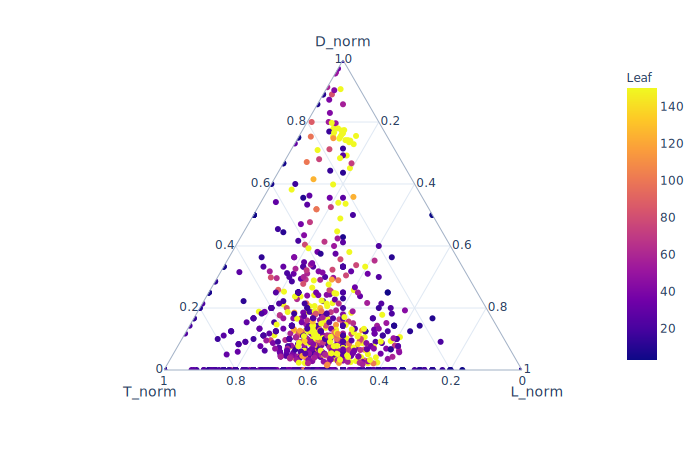

In [19]:
ap.ternary_ecce_plot(ecce_df, renderer="svg")

And we can see the distribution

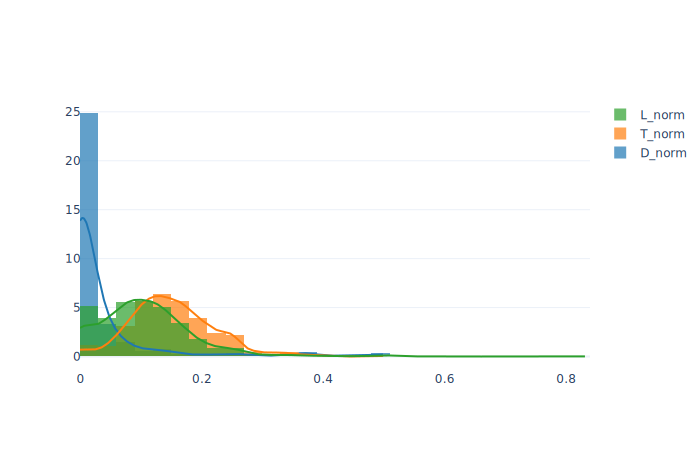

In [20]:
ap.dist_ecce_plot(ecce_df, show_hist=True, renderer="svg")

Unluckily, eccetera saves the results of reconciliations losing info on filename. We can find the index of the file of interest and get it however.

In [39]:
indx = ecce_df.index[ecce_df['Index'] == random_gene].tolist()[0]# + 1 # as index are 0-based

In [40]:
ecce_df.iloc[indx]

Index         Phy008FIW9_341454
Leaf                         24
Leaves_int                   46
D                             0
T                            11
L                            12
D_norm                      0.0
T_norm                  0.23913
L_norm                  0.26087
Name: 339, dtype: object

The trees may be saved as recphyloxml files by activating recPhyloXML.reconciliation=true and upload it [here](http://phylariane.univ-lyon1.fr/recphyloxml/recphylovisu)

Thus far, eccetera is quite hard to work with but it gives a support value to each event and it outputs the DTL graph including all reconciliations (sif file) that can be visualized with cytoscape for example!

Thanks to this index (+1!!) we can recover the same reconciled tree as the one we analysed for generax. Thus, we can load the recphyloxml tree and analyse it.

In [41]:
ecce_tree = ("out_ecce_15/ecce_results_phylome_15/reconciliationsFile_" + str(indx+1) + "_canonical_symmetric.recPhyloXML")
ecce_rec = parser.parse(ecce_tree)
ecce_rec.getEventsSummary()

{'duplication': [],
 'loss': ['UNSAMPLED',
  '36',
  'PHANO',
  'ARTOA',
  'UNSAMPLED',
  '21',
  'UNSAMPLED',
  '33',
  '23',
  '27',
  'BLUGR',
  'PHANO',
  '26',
  'TAPDE',
  'AGABI'],
 'transferReception': ['UNSAMPLED',
  '35',
  'SCHPO',
  '341454',
  'UNSAMPLED',
  '23',
  'UNSAMPLED',
  '34',
  'YARLI',
  'LACBI',
  'GIBZE',
  'MYCGR',
  'YARLI',
  '341454']}

Thanks to this format we can also infer the total events for each species and visualize it like before with pie charts.

In [42]:
counts_ecce = ap.obtain_ecce_counts("out_ecce_15/ecce_results_phylome_15")

In [44]:
ann_sptree = ap.annotate_sptree_counts(ecce_rec.spTree, counts_ecce)
ap.viz_pies_tree(ann_sptree, show=False, render="./out_dir15/plot_species_events_ecce.png") # circular=True

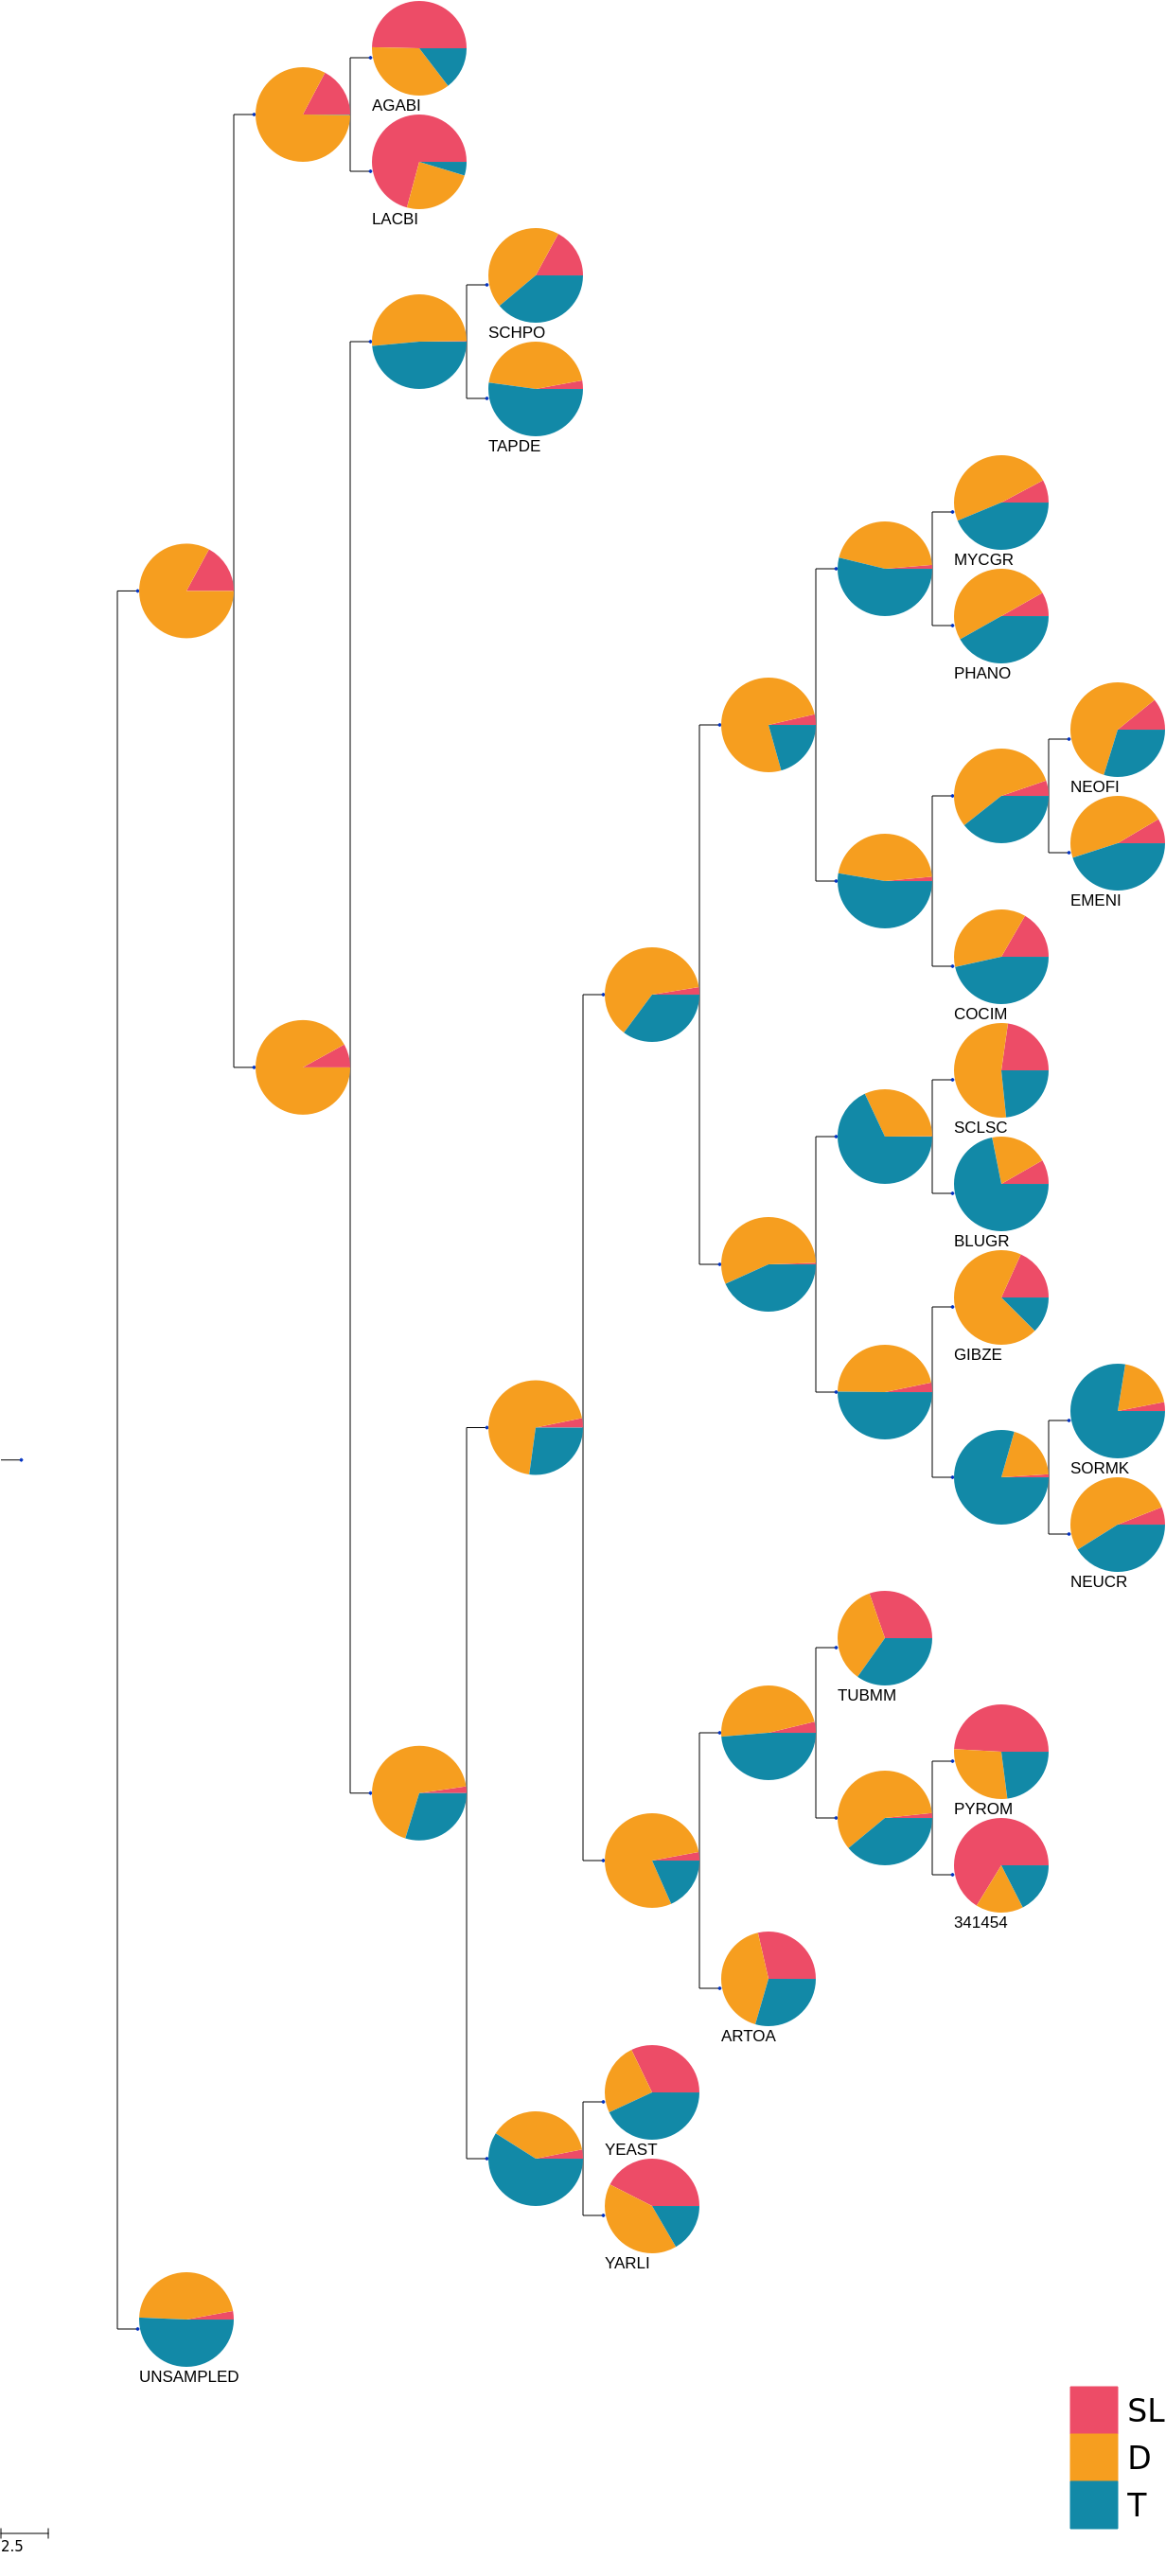

In [45]:
Image(filename='./out_dir15/plot_species_events_ecce.png') 

As we now have both reconciled tree in the same format we may want to compare them. To do this we can see which events are shared and which are not. First though, we must obtain a way to translate internal node names as both methods give them different names.

In [46]:
matches = ap.get_translation_dict(ecce_rec, grax_rec)
ap.compare_rectree(ecce_rec, grax_rec, matches)

({'duplication': set(),
  'loss': {'AGABI',
   'BLUGR',
   'node_11',
   'node_13',
   'node_16',
   'node_8',
   'node_9'},
  'transferReception': {'YARLI', 'node_13', 'node_17', 'node_3'}},
 {'duplication': {'341454', 'YARLI'},
  'loss': {'GIBZE', 'YEAST', 'node_10'},
  'transferReception': {'COCIM', 'SCLSC', 'node_0'}},
 {'duplication': set(),
  'loss': {'ARTOA', 'PHANO', 'TAPDE', 'node_15'},
  'transferReception': {'341454', 'GIBZE', 'LACBI', 'MYCGR', 'SCHPO'}})

The first dictionary has the events only in ecce, the second only in grax and the third has common events.

Further, we may also want to compare the events for species counts found in both method. In this case we can use both counts dataframe and visualize them as barplots (the first three bars are for eccetera and the latter are for generax).

In [50]:
out_tree = ap.annotate_sptree_counts_both(
    ecce_rec.spTree, counts_ecce, events_df, matches
)

ap.viz_both_bars_tree(out_tree, show=False, render="./out_dir15/plot_species_events_both_bars.png")

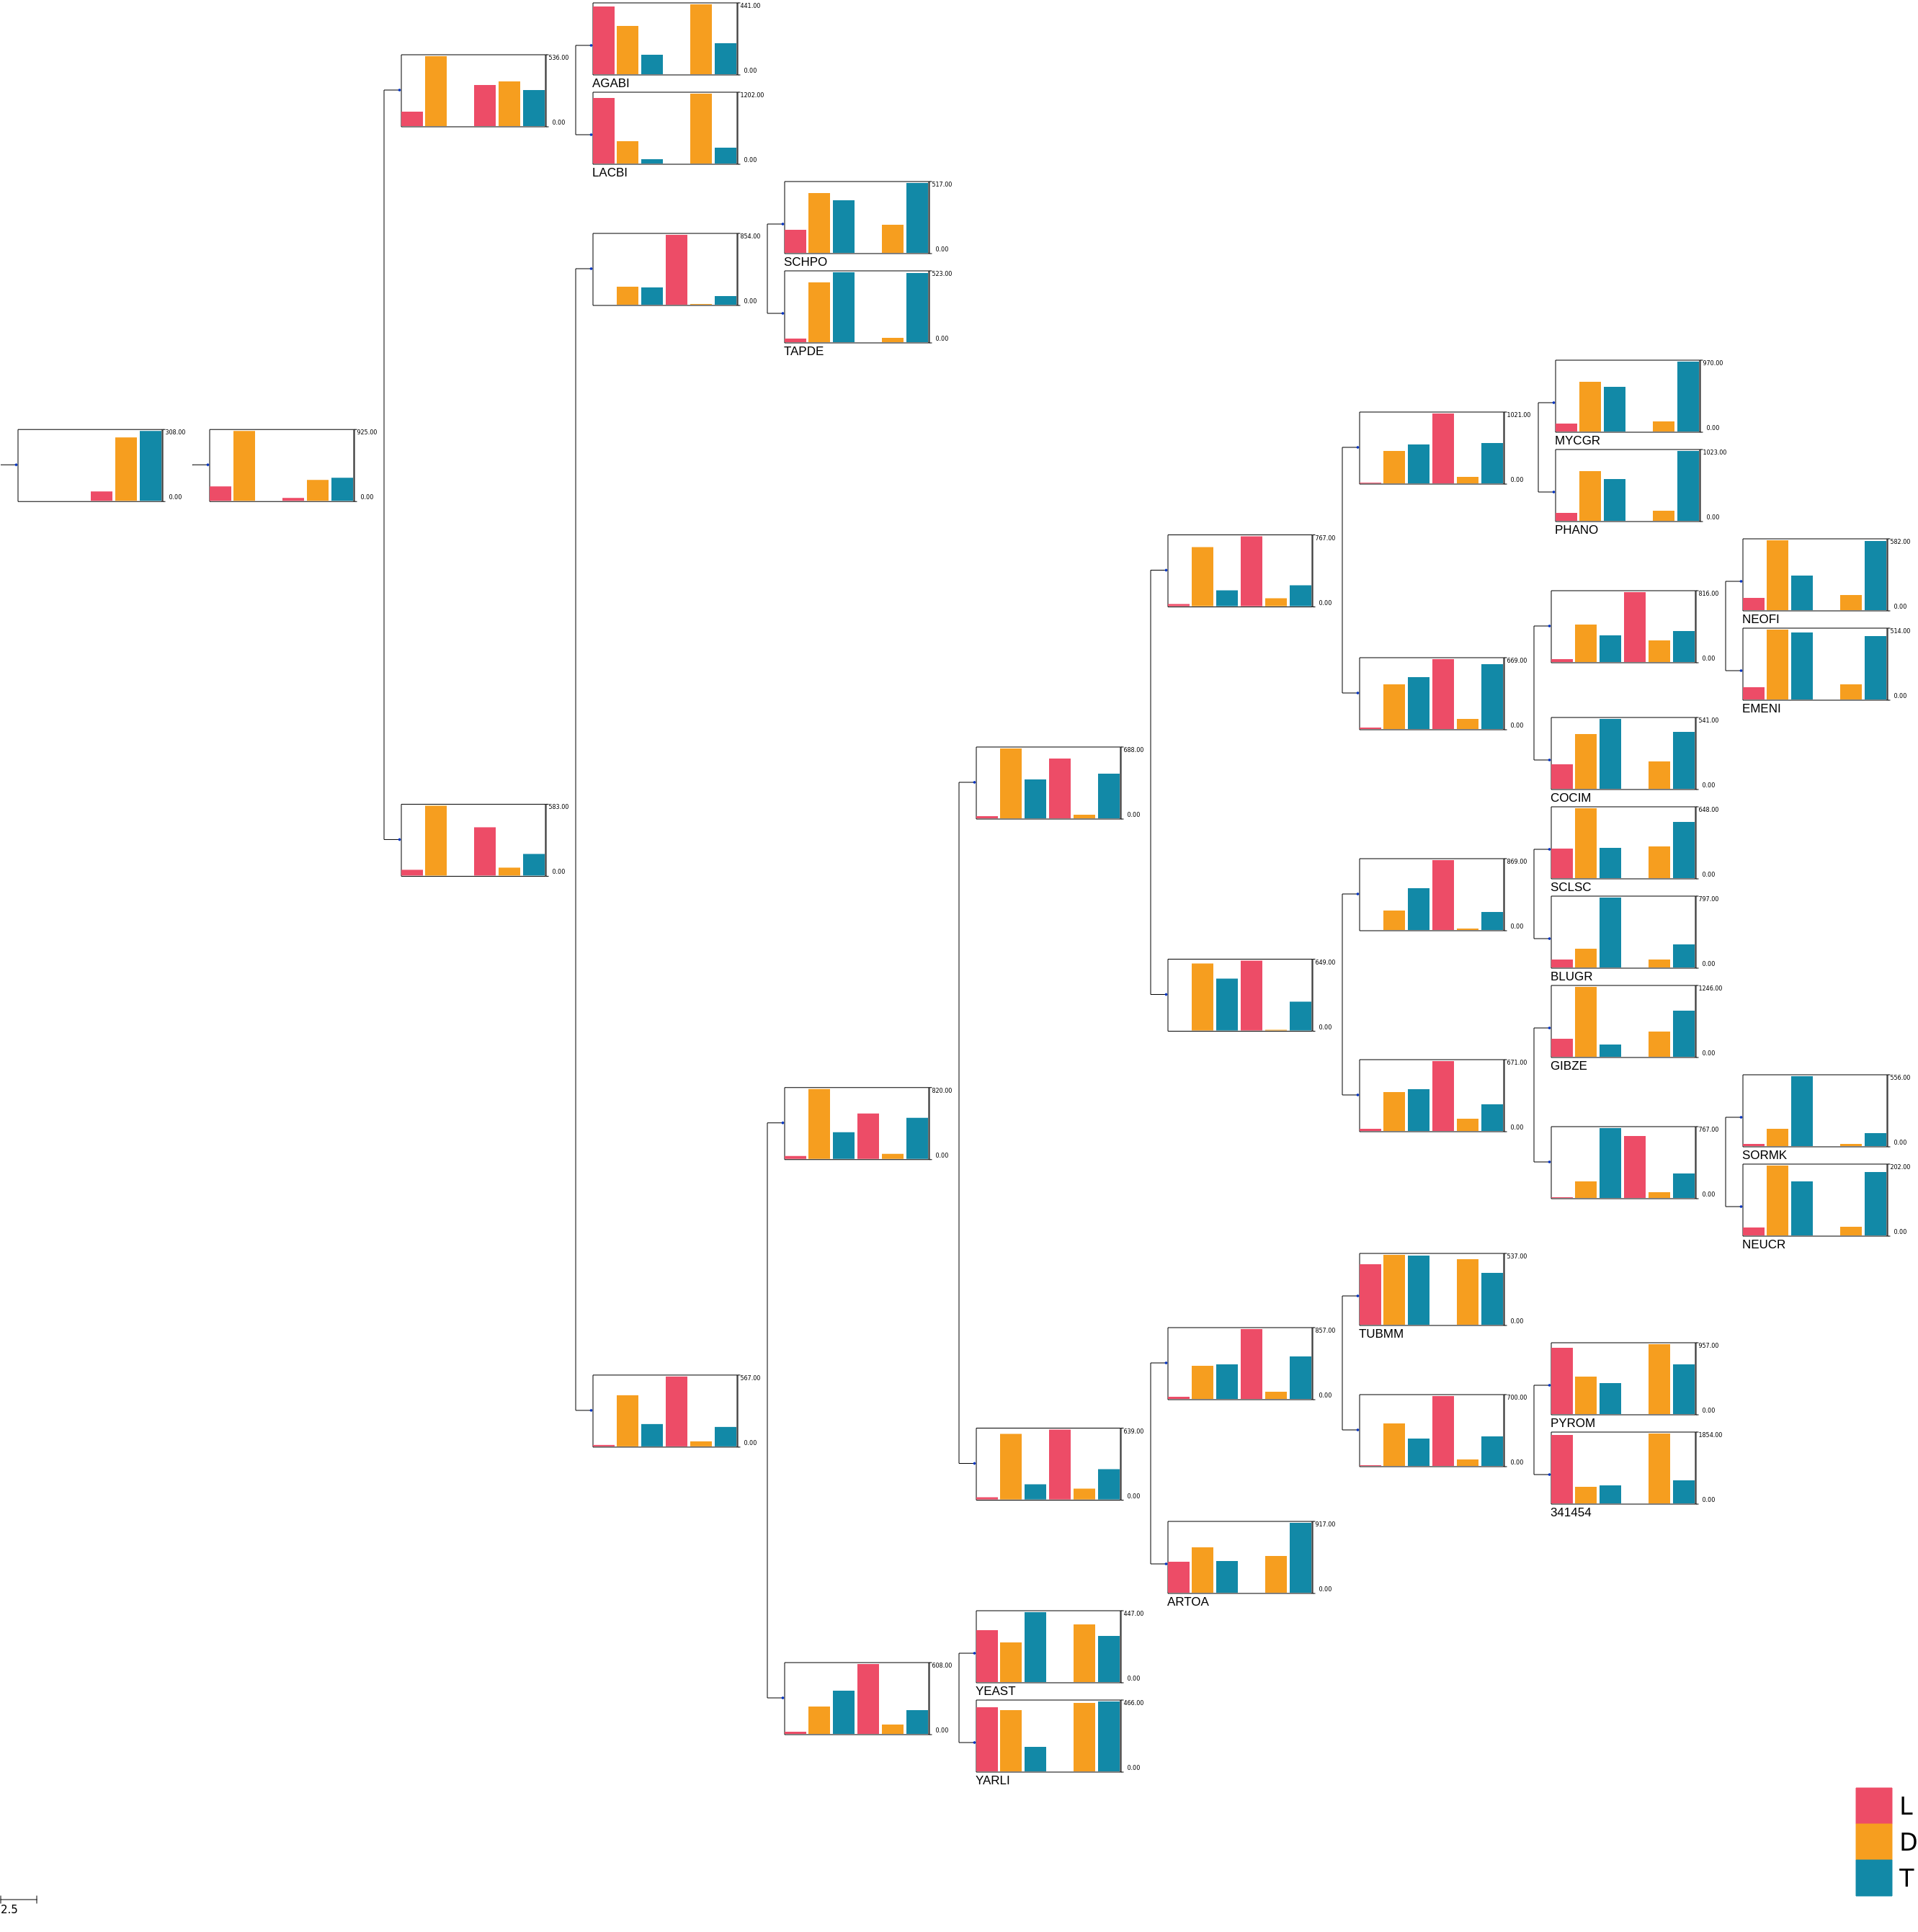

In [51]:
Image(filename='./out_dir15/plot_species_events_both_bars.png') 

We can see that the two methods yield very different results. This is because GeneRax annotates Losses on internal nodes whereas eccetera mostly annotates losses in leaves. The opposite can be said for duplications.

### Abaccus

Abaccus is an algorithm first introduced [here](https://www.frontiersin.org/articles/10.3389/fmicb.2016.02001/full) to analyse differences between a gene tree and a user-curated taxonomy. The algorithm was updated to version 1.2 and now it can support a species tree as input.


In [27]:
sptree_tree = Tree(sptree)
phy_info = "./test_data/phylome_info15.txt"
tax_dict_i = ap.get_tax_dict_info(phy_info)
whole_tax_dict = ap.get_taxonomic_df(tax_dict_i)

abaccus_script = "../Abaccus/scripts/abaccus.py"
out_tax = outDir + "/taxon_euka.csv"

In [28]:
print(tax_dict_i)

{'YEAST': '4932', 'YARLI': '4952', 'NEUCR': '5141', 'SCLSC': '5180', 'AGABI': '5341', 'COCIM': '5501', 'GIBZE': '5518', 'LACBI': '29883', 'BLUGR': '34373', 'EMENI': '162425', 'SCHPO': '284812', 'PHANO': '321614', 'NEOFI': '331117', '341454': '341454', 'TUBMM': '656061', 'ARTOA': '756982', 'SORMK': '771870', 'MYCGR': '1047171', 'PYROM': '1076935', 'TAPDE': '1097556'}


In order to get the taxonomy file needed to run standard abaccus we can use the taxonomy dictionary to get lineage information for all species. As Abaccus assumes no prokaryotic entries are in this file Bacteria will not be added to this file.

In [29]:
ap.get_abaccus_taxo(tax_dict_i, out_tax)

Taxonomy file created. Remember to check if all is okay or eventually add euka entries manually.


The resulting file looks like this. By default, selected column are "species", "genus", "family", "order", "class", "phylum", "kingdom", "superkingdom". If set_cols=False the column will be the ones present in all species.

In [30]:
import pandas as pd
pd.read_csv(out_tax, sep=";")

,taxaid,mnemo,species,genus,family,order,class,phylum,kingdom,superkingdom
0,4932,YEAST,Saccharomyces cerevisiae,Saccharomyces,Saccharomycetaceae,Saccharomycetales,Saccharomycetes,Ascomycota,Fungi,Eukaryota
1,4952,YARLI,Yarrowia lipolytica,Yarrowia,Dipodascaceae,Saccharomycetales,Saccharomycetes,Ascomycota,Fungi,Eukaryota
2,5141,NEUCR,Neurospora crassa,Neurospora,Sordariaceae,Sordariales,Sordariomycetes,Ascomycota,Fungi,Eukaryota
3,5180,SCLSC,Sclerotinia sclerotiorum,Sclerotinia,Sclerotiniaceae,Helotiales,Leotiomycetes,Ascomycota,Fungi,Eukaryota
4,5341,AGABI,Agaricus bisporus,Agaricus,Agaricaceae,Agaricales,Agaricomycetes,Basidiomycota,Fungi,Eukaryota
5,5501,COCIM,Coccidioides immitis,Coccidioides,Onygenales,Onygenales,Eurotiomycetes,Ascomycota,Fungi,Eukaryota
6,5518,GIBZE,Fusarium graminearum,Fusarium,Nectriaceae,Hypocreales,Sordariomycetes,Ascomycota,Fungi,Eukaryota
7,29883,LACBI,Laccaria bicolor,Laccaria,Tricholomataceae,Agaricales,Agaricomycetes,Basidiomycota,Fungi,Eukaryota
8,34373,BLUGR,Blumeria graminis,Blumeria,Erysiphaceae,Erysiphales,Leotiomycetes,Ascomycota,Fungi,Eukaryota
9,162425,EMENI,Aspergillus nidulans,Aspergillus,Aspergillaceae,Eurotiales,Eurotiomycetes,Ascomycota,Fungi,Eukaryota


Then in order to run abaccus over all trees in besttrees file, this function can be used. If greasyfile is non-empty the commands will be saved in a txt file (stored in out_dir) that can really easily be run as a greasy command in MN4. Otherwise, the script will directly run.

In [31]:
ap.run_abaccus(
    abaccus_script, treeFile, outDir, taxonomy=out_tax, greasyfile="greasy15.txt"
)

Otherwise, Abaccus can be simply run with the species tree as taxonomy. In this case, if there are prokaryotic species you may want to run this command first. If proka entries are found it will write proka_mnemo.txt in out_dir that will be needed to run Abaccus later.

In [32]:
ap.get_proka_file(whole_tax_dict, out_dir=outDir)

No prokaryotic entry found!


Finally, to run Abaccus in phylogeny mode it's enough to put the path to the newick file of the species tree in taxonomy param. It's essential that the tree has the nwk (nw or newick) extension so that Abaccus work properly.

In [33]:
sptree_nwk = "test_data/rooted_phylome_15_sp_duptree.nwk"

In [34]:
ap.run_abaccus(
    abaccus_script, treeFile, outDir, taxonomy=sptree_nwk, greasyfile="greasy15_phylo.txt"


SyntaxError: unexpected EOF while parsing (3563121359.py, line 2)

## Pipelines

For all three methods there is a respective python pipeline if the user may want to get results with a few lines of code. In all cases the user has to specify the path to the readal exe. If --partition is specified the partition file will be saved and the user can change --prop, --at_least and --max_length for all three methods.

#### GeneRax

To do GeneRax 1 use -m (or --method) grax. 

To use generax in MN4 use:

module purge
module load gcc impi generax 

then -e may simply be generax

`python pipelines/run_discordance.py -p 13 -e /home/giacomo/master-thesis/softwares/GeneRax/build/bin/generax -t test_data/best_trees13.txt -m grax -s test_data/rooted_phylome_13_sp_duptree.nwk -a test_data/
all_algs_13/ --threads 4`


#### ecceTERA

To do ecceTERA 1 use -m (or --method) ecce.

To use eccetera in MN4 use:

module load eccetera/1.2.5

then -e may simply be eccetera

`python pipelines/run_discordance.py -p 13 -e /home/giacomo/master-thesis/softwares/ecceTERA/bin/ecceTERA -t test_data/best_trees13.txt -m ecce -s test_data/rooted_phylome_13_sp_duptree.nwk`

#### Abaccus

You can find Abaccus script [here](https://github.com/Gabaldonlab/Abaccus). In both cases the user has to give the phylome info file in order for the pipeline to work.

###### Phylo

To do this method use -m abac_phylo.

`python pipelines/run_discordance.py -p 13 -e /home/giacomo/master-thesis/Abaccus/scripts/abaccus.py -t test_data/best_trees13.txt -m abac_phylo --phy_info test_data/phylome_info13.txt -s test_data/rooted_ph
ylome_13_sp_duptree.nwk`

###### Taxonomy

To do this method use -m abac_taxa.

`python pipelines/run_discordance.py -p 13 -e /home/giacomo/master-thesis/Abaccus/scripts/abaccus.py -t test_data/best_trees13.txt -m abac_taxa --phy_info test_data/phylome_info13.txt -s test_data/rooted_phy
lome_13_sp_duptree.nwk`


### Phylome analysis